https://www.kaggle.com/code/samehraouf/fashion-recommendation-system-with-mobilenetv2


In [ ]:
# !pip install pytz
# !pip install scikit-learn

# Import essential libraries for data manipulation, image processing, and ML

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import webbrowser
import random

# Load and Filter Dataset

In [3]:
# Define paths to metadata and image directory
metadata_path = r'styles.csv'
images_path = r'fashion/archive/images'

# Load CSV and filter relevant columns, removing rows with missing values
df = pd.read_csv(metadata_path, on_bad_lines='skip')
df = df.dropna(subset=['id', 'articleType', 'baseColour', 'gender'])

# Limit to a smaller dataset for faster testing
df = df.head(5000)

# Add image filename and filepath columns
df['filename'] = df['id'].astype(str) + '.jpg'
df['filepath'] = df['filename'].apply(lambda x: os.path.join(images_path, x))

# Filter only existing images
df['exists'] = df['filepath'].apply(os.path.exists)
print("✅ Number of existing images found:", df['exists'].sum())

# Keep only valid images
df = df[df['exists']].reset_index(drop=True)

✅ Number of existing images found: 2309


# Prepare Feature Extraction Model (MobileNetV2)¶

In [4]:
# Prepare a MobileNetV2 model without pre-trained weights and without the top classifier
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ Feature extraction model is ready (MobileNetV2 without weights).")

C:\Users\DanielSantana\AppData\Local\Temp\ipykernel_6088\2551767622.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


✅ Feature extraction model is ready (MobileNetV2 without weights).


# Extract Visual Feature

In [5]:
def extract_features(filepaths):
    """
    Extract features from image files using MobileNetV2.
    Returns a numpy array of image embeddings.
    """
    features = []
    for path in tqdm(filepaths, desc='Extracting visual features'):
        try:
            img = image.load_img(path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            feat = model.predict(x, verbose=0)
            features.append(feat.flatten())
        except Exception as e:
            print(f"⚠️ Error reading {path}: {e}")
            features.append(np.zeros(1280))  # Fallback zero vector
    return np.array(features)

# Run feature extraction
features_array = extract_features(df['filepath'])
df['features'] = list(features_array)

print("✅ Visual features extracted. Shape:", features_array.shape)



Extracting visual features: 100%|██████████| 2309/2309 [08:35<00:00,  4.48it/s]

✅ Visual features extracted. Shape: (2309, 1280)


# Encode Textual Metadata

In [6]:
# Convert text features into numeric form
text_features = df[['articleType', 'baseColour', 'gender']].astype(str)

# Apply Label Encoding to each categorical column
for col in text_features.columns:
    le = LabelEncoder()
    text_features[col] = le.fit_transform(text_features[col])

df['text_vector'] = list(text_features.values)
print("✅ Textual metadata encoded.")

✅ Textual metadata encoded.


# Combine Visual and Textual Features

In [7]:
# Combine image features with encoded text data
combined_features = []
for i in range(len(df)):
    visual = df.iloc[i]['features']
    text = df.iloc[i]['text_vector']
    combined = np.concatenate((visual, text))
    combined_features.append(combined)

combined_features = np.array(combined_features)
print("✅ Combined features shape:", combined_features.shape)

✅ Combined features shape: (2309, 1283)


# Compute Cosine Similarity Between Products

In [8]:
# Compute similarity scores for all products
similarity = cosine_similarity(combined_features)
print("✅ Cosine similarity matrix computed.")

✅ Cosine similarity matrix computed.


# Define Function to Visualize Similar Items

In [9]:
def show_similar(index, top_n=5):
    """
    Show the most similar items to a given product index.
    """
    print(f"\n🔍 Query Product: {df.iloc[index]['articleType']} - {df.iloc[index]['baseColour']}")
    
    query_path = df.iloc[index]['filepath']
    
    # Plot original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    img = cv2.imread(query_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")
    plt.axis('off')

    # Find top-N most similar items
    scores = list(enumerate(similarity[index]))
    top_similar = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n + 1]

    # Display similar images
    for i, (idx, score) in enumerate(top_similar):
        sim_img = cv2.imread(df.iloc[idx]['filepath'])
        plt.subplot(1, top_n + 1, i + 2)
        plt.imshow(cv2.cvtColor(sim_img, cv2.COLOR_BGR2RGB))
        title = f"{df.iloc[idx]['articleType']} ({score:.2f})"
        plt.title(title, fontsize=9)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Try the Recommendation System

### Oferece produtos selelhantes no Amazon

In [32]:

def buscar_na_amazon(index):
    artigo = df.iloc[index]['articleType']
    cor = df.iloc[index]['baseColour']
    query = f"{artigo} {cor}"
    url = f"https://www.amazon.com/s?k={query.replace(' ', '+')}"
    print(f"🔎 Buscando no Amazon: {query}")
    webbrowser.open(url)

def buscar_no_google_shopping(index):
    artigo = df.iloc[index]['articleType']
    cor = df.iloc[index]['baseColour']
    query = f"{artigo} {cor}"
    url = f"https://www.google.com/search?tbm=shop&q={query.replace(' ', '+')}"
    print(f"🔎 Buscando no Google Shopping: {query}")
    webbrowser.open(url)
   



🔍 Query Product: Kurta Sets - Black


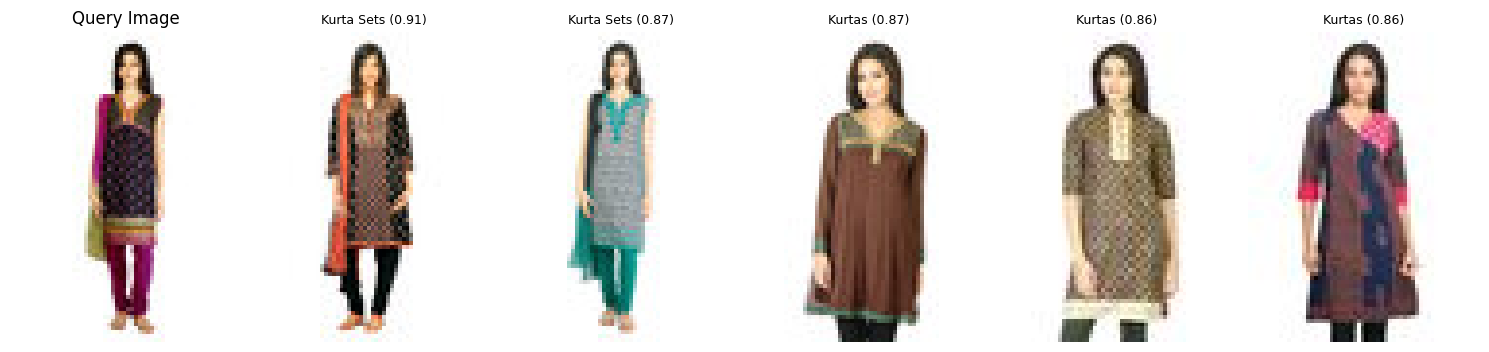

🔎 Buscando no Amazon: Kurta Sets Black

🔍 Query Product: Kurtas - Cream


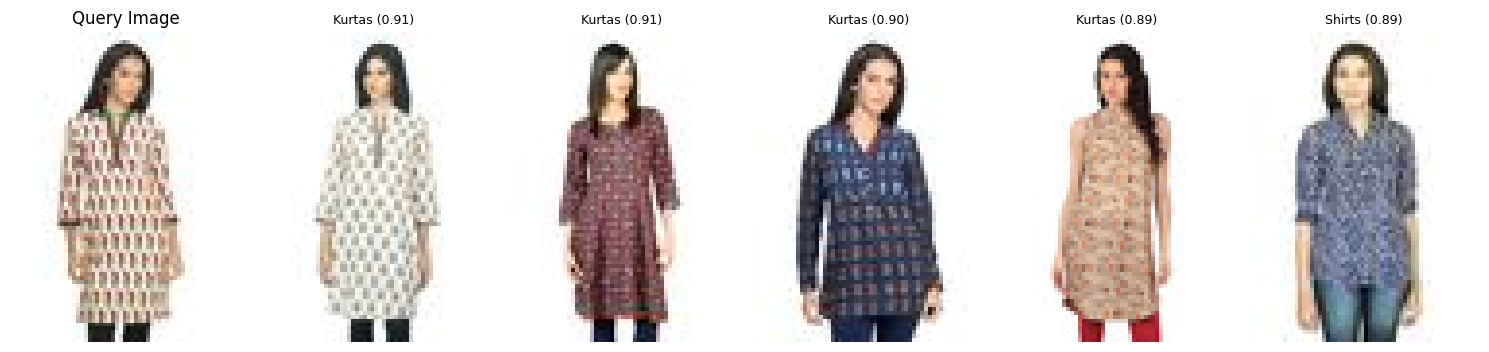

🔎 Buscando no Amazon: Kurtas Cream

🔍 Query Product: Sports Sandals - Blue


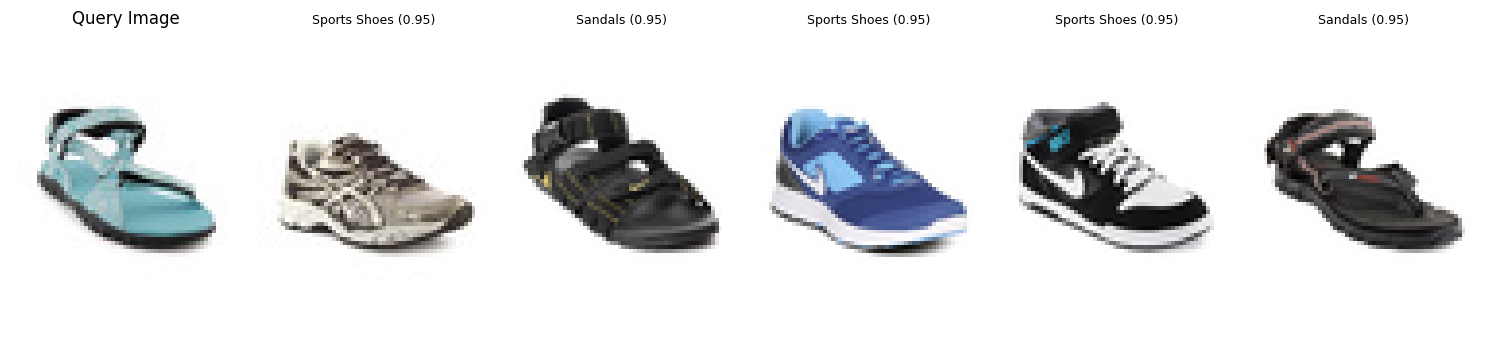

🔎 Buscando no Amazon: Sports Sandals Blue
✅ Índices aleatórios utilizados: [1018, 152, 1016]


In [ ]:
# Seleciona 3 índices aleatórios válidos
random_indices = random.sample(range(len(df)), 3)

# Exibe os resultados da busca na Amazon para cada um
for idx in random_indices:
    show_similar(index=idx, top_n=5)
    buscar_na_amazon(index=idx)


# Exibe os índices utilizados
print("✅ Índices aleatórios utilizados:", random_indices)

### Recomendações Google Shopping


🔍 Query Product: Kurta Sets - Black


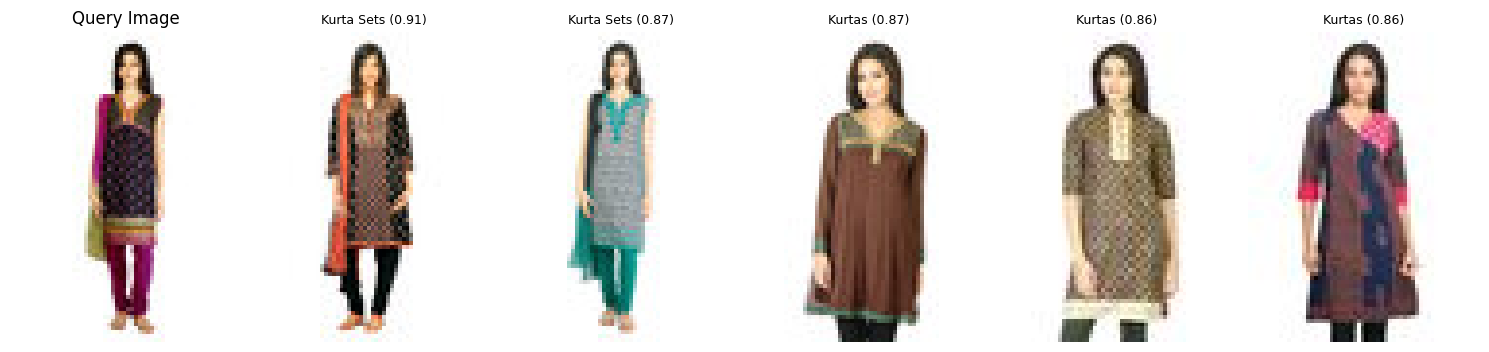

🔎 Buscando no Google Shopping: Kurta Sets Black

🔍 Query Product: Kurtas - Cream


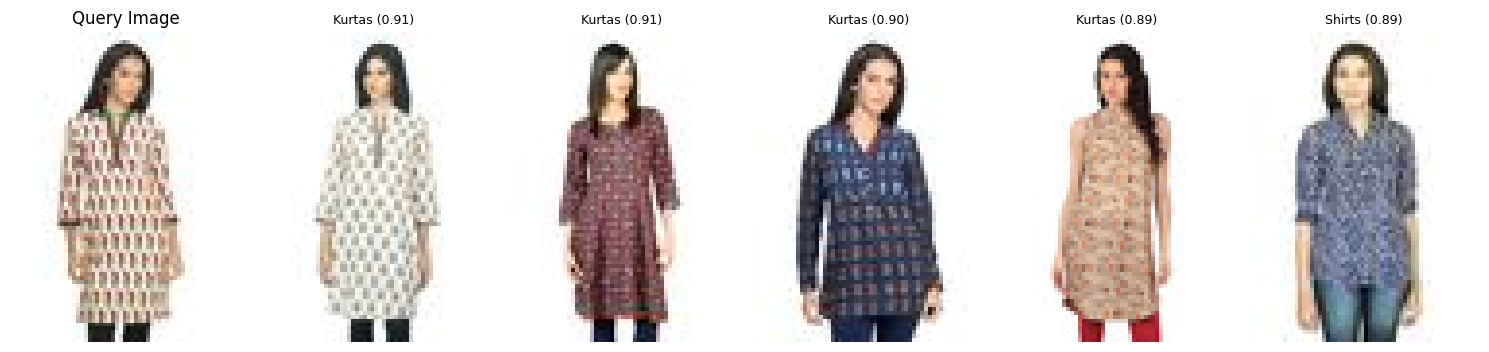

🔎 Buscando no Google Shopping: Kurtas Cream

🔍 Query Product: Sports Sandals - Blue


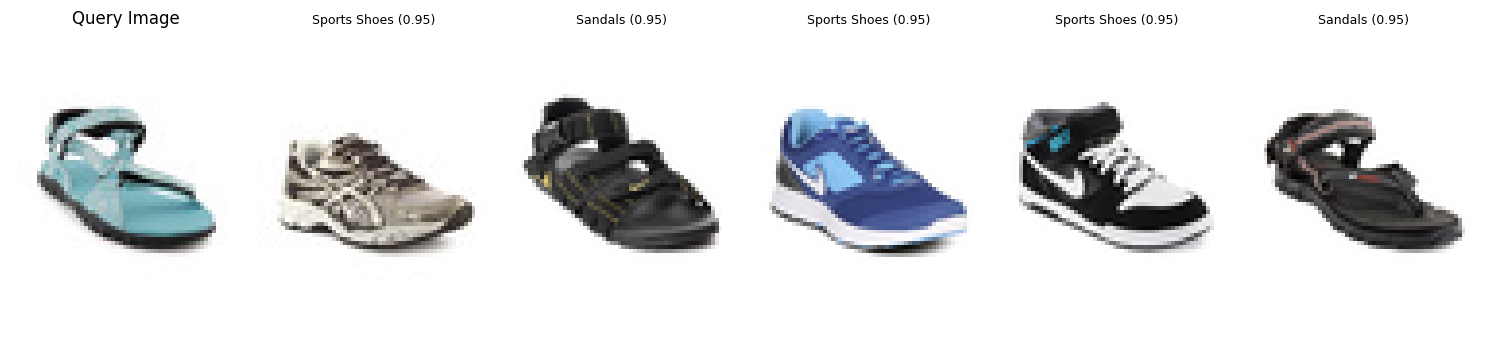

🔎 Buscando no Google Shopping: Sports Sandals Blue
✅ Índices aleatórios utilizados: [1018, 152, 1016]


In [38]:
# Exibe recomendações visuais e links da Google Shopping para cada índice
for idx in random_indices:
    show_similar(index=idx, top_n=5)
    buscar_no_google_shopping(index=idx)

# Exibe os índices utilizados
print("✅ Índices aleatórios utilizados:", random_indices)

